In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [3]:
#get mnist
print("Loading Fashion-MNIST dataset...")
mnist = fetch_openml('Fashion-MNIST', version=1)
X,y = mnist['data'], mnist['target']

print("Encoding data...")

y = y.astype(int)
X = X/255.0

#one-hot encode labels in y
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(np.array(y).reshape(-1,1)) #y.shape = (70000, 10)
#X = X.T #Input format is n*m where m is samples, and current format is 70000*784. Changes to 784*70000


print("Splitting data...")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)




layerDims = [784,100,10] #1 hidden layer specified

print("Data loaded successfully")


Loading Fashion-MNIST dataset...
Encoding data...
Splitting data...
Data loaded successfully


In [19]:
class FNN_classifier:

    def __init__(self):
        self.params = {}
        self.accHistory = []

    def initializeParams(self, layerDims):
        #initialize weights and biases of the network given array of dimensions of each layer
        np.random.seed(42)
        for i in range(1,len(layerDims)):
            '''
                W_i is a 2 dimensional matrix that is initialized to random values with
                dimensions n*m where n is the layers in the current dimension and
                m is the layers of the previous dimension. Each value is multiplied by 0.01
                to avoid exploding gradients. 
                The shape of the n*m matrix allows it to be multiplied in the current layer in
                forward propagation by the result of the previous layer which is an m-dimensional
                vector (Matrix mult: n*m x m*1). This results in an n dimensional vector that can then
                be taken to the next layer to repeat the process. 

                b_i is an n dimensional vector of zeros representing biases. biases don't start
                with random values like weights do. 

                Multiplication structure for a 2 by 4 weight metrix to create the linear hypothesis
                (m and n here are unrelated to previous m and n):

                [a b c d]   [i]   [m]   [o]
                [e f g h] X [j] + [n] = [p]
                            [k] 
                            [l]
            '''
            self.params['W' + str(i)] = np.random.randn(layerDims[i],layerDims[i-1])*0.1
            self.params['b' + str(i)] = np.zeros((layerDims[i],1))

        
        return self.params
    
    """
    ------------------------------------
    Activation functions
    """
    #Default value, can be changed
    activation = "relu"

    #functions return the value of the function given input Z and returns Z for caching
    def relu(self,Z):
        return np.maximum(0,Z), Z
    
    def sigmoid(self,Z):
        return 1/(1+np.exp(-0.25*Z)), Z
    
    def tanh(self,Z):
        return np.tanh(2*Z), Z
    
    def softmax(self,Z):
        """
        ex. for a 3 element vector:
        Z
        """
        zexp = np.exp(Z - np.max(Z,axis=0,keepdims=True)) #Apparently this is a trick that prevents overflow
                                    #This will automatically make it so that e^largest value = e^0 = 1
                                    #This is also mathematically equivalent to regular softmax
        return zexp/np.sum(zexp, axis=0, keepdims = True), Z
    
    """
    ------------------------------------
    """
    def forwardProp(self,X):
        X = X.T
        #X is the incoming input matrix
        A = X
        caches = [] #stores tuples of the linear and activation caches for each layer of the network

        L = len(self.params)//2 #self.params is twice as long as the number of layers due to W_i and b_i

        for i in range(1, L+1):
            prevA = A

            #Z = Wx + b - "linear hypothesis"
            
            Z = np.dot(self.params['W' + str(i)],prevA) + self.params['b' + str(i)]

            #Caching important values from linear hypothesis
            linearCache = (prevA, self.params['W' + str(i)], self.params['b' + str(i)])

            #Caching important values from activation. Activation function returns the 
            #value of the function itself and the input Z, the result of the linear hypothesis
            
            func = 0
            if i == L: #This is the final layer, where softmax is implemented.
                func = self.softmax(Z)
                #print(f"final layer reached, softmaxed. {L}")
            elif self.activation == "relu":
                #print(f"relu'd{L}")
                func = self.relu(Z)
            elif self.activation == "sigmoid":
                func = self.sigmoid(Z)
            elif self.activation == "tanh":
                func = self.tanh(Z)
            else:
                raise ValueError("Activation function not supported")
            
            A, activationCache = func

            cache = (linearCache,activationCache)
            caches.append(cache)

        return A, caches


    #Now that forward propagation is done, the loss function needs to be defined
    def crossEntropyLoss(self, yTrue, yPred):
        yTrue = yTrue.T
        """
        Computes cost function for general cross entropy loss, used for multiclass classification
        """
        #accounts for floating point inaccuracies, keeps values between 0 and 1
        yPred = np.clip(yPred, 1e-15, 1-1e-15) 

        #returns a vector of the individual sample losses
        
        losses = -np.sum(yTrue*np.log(yPred),axis=1)
        
        #Determines total cost by taking the average of the loss across the entire dataset. 
        cost = np.mean(losses)
        return cost


    #Backprop helper function that runs it for a single layer
    def stepBack(self, dA, cache, isOutput = False):
        #dA is the gradient of the loss with respect to A, dL/dA
        #unpacking cache
        linearCache, activationCache = cache
        prevA, W, b = linearCache
        Z = activationCache
        m = prevA.shape[1] #gets number of samples


        if isOutput:
            dZ = dA
        else:
            if self.activation == "relu":
                dZ = dA * (Z>0) #Interestingly enough, you can multiply numbers by booleans in python.
                #This multiplies dA by the derivative of relu which is 1 if positive and 0 if not. 
            elif self.activation == "tanh":
                dZ = dA * (1-np.tanh(Z)**2)
                #for y = tanh(x), dy/dx = 1-tanh(x)^2
            elif self.activation == "sigmoid":
                dZ = dA*self.sigmoid(Z)[0]*(1-self.sigmoid(Z)[0])
                #for y = sigmoid(x), dy/dx = sigmoid(x)*(1-sigmoid(x))
            else:
                raise ValueError("Activation function not supported")
        
        #Now, we can compute gradients for W, b, and prevA
        dW = (1/m)*np.dot(dZ,prevA.T)
        db = (1/m)*np.sum(dZ, axis=1, keepdims = True)
        prevdA = np.dot(W.T, dZ)

        return prevdA, dW, db
        
    #Now that the stepback function is defined for each layer going backwards, we can do backprop
    def backprop(self, AL, yPred, caches):
        grads = {}
        L = len(caches)
        
        m = AL.shape[1] 
        #Remember, AL is the final activations for every sample represented as a matrix of column vectors
        '''
        ex.      [p0a p0b p0c p0d p0e]
                 [p1a p1b p1c p1d p1e]
                 [p2a p2b p2c p2d p2e]
                 [p3a p3b p3c p3d p3e]
                 [p4a p4b p4c p4d p4e]
        Where each final letter of a term represents a different sample. AL.shape[1] returns the number of columns,
        also the number of samples. 
        '''
        yPred = yPred.T

        dAL = AL - yPred
        #Gradient of the loss function with respect to AL for general cross entropy loss.

        currentCache = caches[L-1]
        grads['dA' + str(L-1)], grads['dW' + str(L-1)], grads['db' + str(L-1)] = self.stepBack(dAL, currentCache, isOutput=True)

        for i in reversed(range(L-1)):
            currentCache = caches[i]
            prevdAtemp, dWtemp, dbtemp = self.stepBack(grads['dA' + str(i+1)], currentCache)

            grads['dA' + str(i)] = prevdAtemp
            #i+1 is used in order to match up the dA gradient used to calculate the weights and biases
            #of the following layer.
            grads['dW' + str(i)] = dWtemp
            grads['db' + str(i)] = dbtemp
#        print(grads.keys())
        return grads
    
    #Now its time for gradient descent!!! Actually updating the weights and biases according to calculated
    #grads and the learning rate, a hyperparameter.
    '''
    The learning rate hyperparameter exists to facilitate the size of steps in gradient descent. 
    If the learning rate is too small, convergence to a local minimum takes too long. 
    If the learning rate is too big, the process can overshoot and diverge, not reaching the minimum.
    '''
    #Also, we don't know when a minimum is reached, we just try to get close. More epochs exist to try
    #and approach the minimum of the cost function. 
    '''
    Many optimizers use dynamic learning rates, decreasing step size as a minimum seems to be approached
    to get a more accurate estimate without overshooting.
    '''
    def updateParameters(self, grads, learningRate):
        L = len(self.params) // 2 #layer number

#        print(L)
        for i in range(L):
            #starting with first hidden layer updating current Weights

            
            
            self.params['W'+str(i+1)] = self.params['W'+str(i+1)] - learningRate*grads['dW'+str(i)]
            #then biases
            self.params['b'+str(i+1)] = self.params['b'+str(i+1)] - learningRate*grads['db'+str(i)]

            '''
            W_new = W - lr*grad_b
            b_new = b - lr*grad_b

            What it looks like to me is a steeper negative gradient will increase a weight ot a bias
            while a positive gradient value decreases the weight or the bias.

            A positive gradient means that increasing that parameter would increase the cost
            (if we consider partial derivative of the cost function with respect to weights or biases),
            so we decrease a weight associated with a positive gradient. Negative gradients decrease the cost
            so we increase those weights to emphasize them more.
            '''

    #Now the function must be trained.
    X_TEST = None
    Y_TEST = None
    def train(self, X, y, layerDims, epochs, lr):

        params = self.initializeParams(layerDims)
        costHistory = []

        for i in range(epochs):
            Y_hat, caches = self.forwardProp(X)
            cost = self.crossEntropyLoss(Y_hat,y)
            costHistory.append(cost)
            grads = self.backprop(Y_hat, y, caches)

            params = self.updateParameters(grads, lr)
            
            accuracy = np.mean(self.predict(FNN_classifier.X_TEST) == np.argmax(FNN_classifier.Y_TEST, axis=1))
            self.accHistory.append(accuracy)
            if i%10 == 0:
                print(f"Epoch {i}: Accuracy = {accuracy * 100:.2f}%")
            
        return params, costHistory
    
    def predict(self, X):
        A, _ = self.forwardProp(X)
#        print(A.shape)
        return np.argmax(A, axis=0) #return highest probability index
    
    '''
    Changes to make:
    - Implement softmax for the final layer in forward prop - DONE
    - Create an optimizer system to dynamically change the learning rate
    - Implement mini-batch gradient descent
    - Number display
    '''


In [20]:
print("Training neural network...")

network = FNN_classifier()
network.activation = "tanh" #relu, tanh, sigmoid are available
FNN_classifier.X_TEST = X_test
FNN_classifier.Y_TEST = y_test

epochs = 150
learningRate = 0.7

params, costHistory = network.train(X_train, y_train, layerDims, epochs, learningRate)


Training neural network...
Epoch 0: Accuracy = 29.66%
Epoch 10: Accuracy = 39.87%
Epoch 20: Accuracy = 29.19%
Epoch 30: Accuracy = 54.04%
Epoch 40: Accuracy = 51.50%
Epoch 50: Accuracy = 65.10%
Epoch 60: Accuracy = 69.94%
Epoch 70: Accuracy = 73.16%
Epoch 80: Accuracy = 74.51%
Epoch 90: Accuracy = 74.86%
Epoch 100: Accuracy = 76.06%
Epoch 110: Accuracy = 72.79%
Epoch 120: Accuracy = 77.14%
Epoch 130: Accuracy = 77.29%
Epoch 140: Accuracy = 75.29%


In [16]:
print("Calculating final accuracy and graphing accuracy and cost histories...")
yPred = network.predict(X_test)

#    print("Unique classes predicted:", np.unique(yPred))
print("First few predictions:\t", yPred[:35])
print("Expected labels:\t", np.argmax(y_test, axis=1)[:35])
#    print(yPred.shape)
#    print(y_test.shape)
accuracy = np.mean(yPred == np.argmax(y_test, axis=1))
print(f"Accuracy: {accuracy * 100:.4f}%")
print(f"Final Cost: {costHistory[-1]}")


Calculating final accuracy and graphing accuracy and cost histories...
First few predictions:	 [3 0 2 8 1 3 4 3 6 5 6 1 4 9 2 1 5 8 8 7 4 4 3 8 4 4 2 4 1 1 0 7 3 9 9]
Expected labels:	 [3 0 2 8 1 3 2 3 8 5 6 1 4 9 2 1 5 8 8 7 4 4 3 8 4 4 2 4 1 1 6 7 3 9 7]
Accuracy: 81.3357%
Final Cost: 9.361410464137991


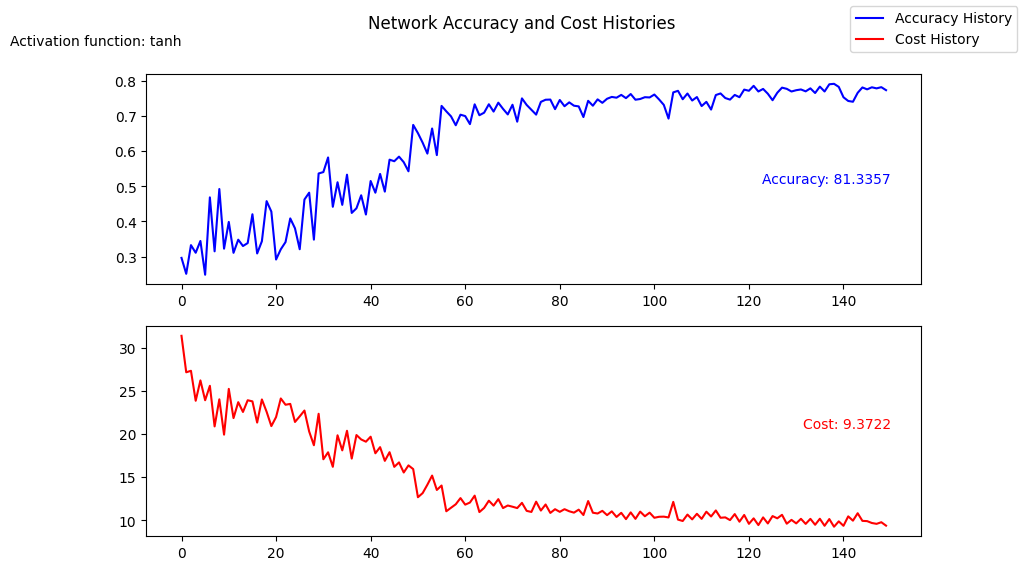

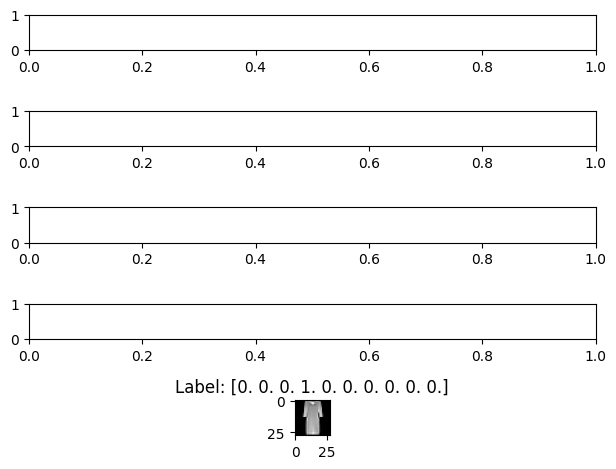

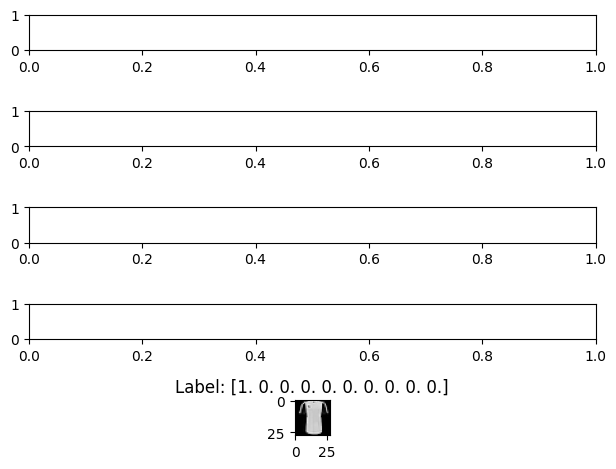

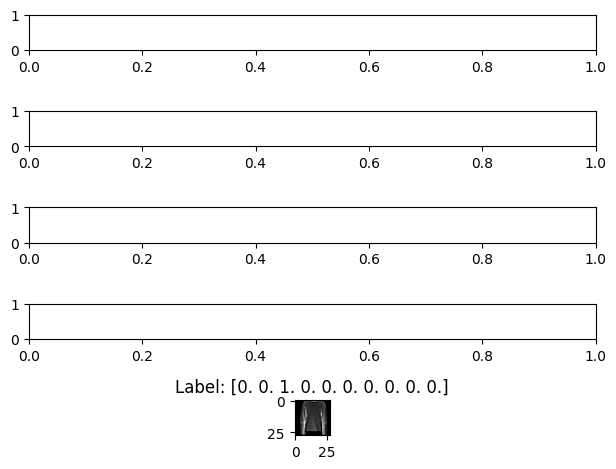

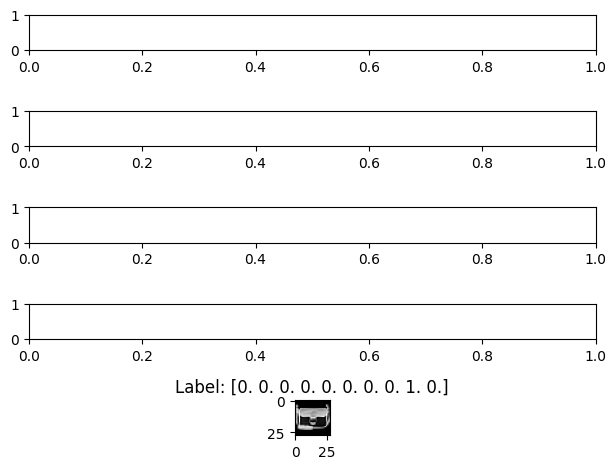

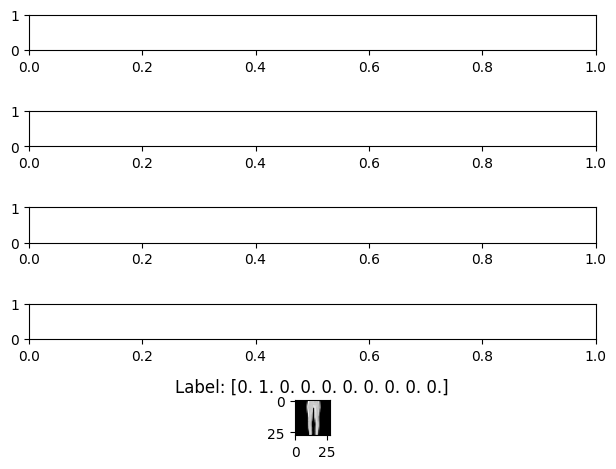

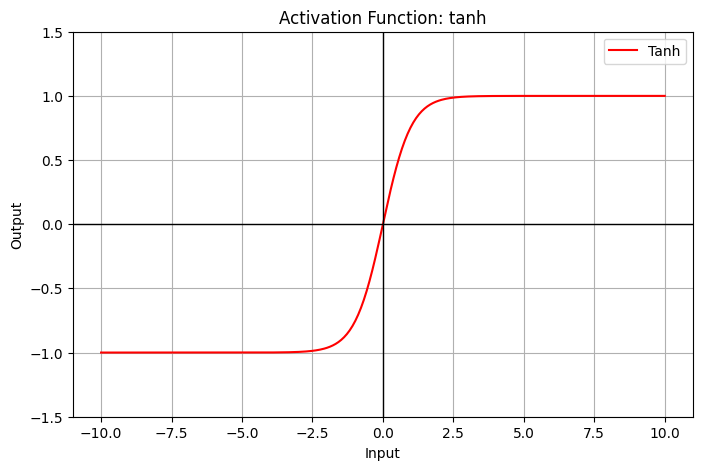

In [21]:
#Make plots to display mnist numbers and plot cost history

fig,axs = plt.subplots(2)
fig.suptitle('Network Accuracy and Cost Histories')
axs[0].plot(network.accHistory, label = 'Accuracy History', color = 'blue')
axs[0].text(epochs, 0.5, f'Accuracy: {accuracy*100:.4f}', 
            verticalalignment='bottom', horizontalalignment='right', fontsize=10, color='blue')
axs[0].text(0, max(network.accHistory) + 0.1, f'Activation function: {network.activation}', 
            verticalalignment='bottom', horizontalalignment='right', fontsize=10, color='black')
axs[1].plot(costHistory, label = 'Cost History', color = 'red')
axs[1].text(epochs, (max(costHistory)-min(costHistory))/2+min(costHistory), f'Cost: {costHistory[-1]:.4f}', 
            verticalalignment='bottom', horizontalalignment='right', fontsize=10, color='red')
fig.legend()
fig.set_figheight(6)
fig.set_figwidth(10)

#display mnist digits - WIP
for i in range(5):
    import matplotlib.pyplot as plt2
    fig2, axs2 = plt2.subplots(5)
    plt2.imshow(X_test.to_numpy()[i].reshape(28,28), cmap='gray')
    plt2.title(f'Label: {y_test[i]}')
    plt2.tight_layout()
plt2.show()
plt.show()


#plot activation function
x = np.linspace(-10,10,400)
sig = network.sigmoid(x)[0]
tanh = np.tanh(x)
relu = np.maximum(0,x)

#plot
import matplotlib.pyplot as plt3
plt3.figure(figsize=(8, 5))
if network.activation == "sigmoid":
    plt3.plot(x, sig, label = 'Sigmoid', color = 'blue')
if network.activation == "tanh":
    plt3.plot(x, tanh, label = 'Tanh', color = 'red')
if network.activation == "relu":
    plt3.plot(x, relu, label="ReLU", color = 'green')
plt3.title("Activation Function: " + network.activation)
plt3.xlabel("Input")
plt3.ylabel("Output")
plt3.grid(True)
plt3.ylim(-1.5,1.5)
plt3.axhline(0, color='black', linewidth=1)
plt3.axvline(0, color='black', linewidth=1)
plt3.legend()
plt3.show()